In [1]:
import numpy as np
import tcbench as tcb
import faiss
import matplotlib.pyplot as plt

In [2]:
vectors_baseline = np.load('artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('artifacts-mirage19/baseline_labels.npy')

vectors_embeddings = np.load('artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('artifacts-mirage19/embeddings_labels.npy')

In [3]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [ ]:
def build_faiss_index(data, labels, train_indices, distance_type, samples_per_class):
    np.random.seed(42)

    filtered_data = data[train_indices]
    filtered_labels = labels[train_indices]
    d = filtered_data.shape[1]

    selected_data = []
    selected_indices = []
    unique_labels = np.unique(filtered_labels)
    for label in unique_labels:
        label_indices = np.where(filtered_labels == label)[0]
        if samples_per_class is None or samples_per_class == -1:
            selected_label_indices = label_indices
        else:
            selected_label_indices = np.random.choice(label_indices, size=min(samples_per_class, len(label_indices)), replace=False)
        selected_data.append(filtered_data[selected_label_indices])
        selected_indices.extend(train_indices[selected_label_indices])
    selected_data = np.vstack(selected_data)
    selected_indices = np.array(selected_indices)

    if distance_type == 'euclidean':
        index = faiss.IndexFlatL2(d)
    elif distance_type == 'cosine':
        norms = np.linalg.norm(selected_data, axis=1, keepdims=True)
        selected_data = selected_data / norms
        index = faiss.IndexFlatIP(d)
    else:
        raise ValueError("Unsupported distance type. Use 'euclidean' or 'cosine'.")

    index.add(selected_data)
    return index, selected_indices

In [38]:
def search_and_compare_labels(data, labels, test_indices, selected_indices, index, metric, limit=None):
    k = 1    
    D, I = index.search(data[test_indices], k)
    test_labels = labels[test_indices]
    neighbor_labels = labels[selected_indices[I.flatten()]].reshape(I.shape)

    top_1_matches = 0
    classified_count = 0

    for i in range(len(test_labels)):
        if limit is not None:
            if metric=="distance" and np.sqrt(D[i, 0]) > limit:
                continue
            if metric=="similarity" and D[i, 0] < limit:
                continue

        classified_count += 1
        top_1_match = test_labels[i] in neighbor_labels[i, :1]

        if top_1_match:
            top_1_matches += 1

    if classified_count > 0:
        top_1_percentage = (top_1_matches / classified_count) * 100
    else:
        top_1_percentage = 0
    
    classified_percentage = (classified_count / len(test_labels)) * 100

    return classified_percentage, top_1_percentage

In [71]:
index_baseline, selected_indices = build_faiss_index(vectors_baseline, labels_baseline, train_val_indices, 'euclidean', 5)
classified_baseline, accuracy_baseline = search_and_compare_labels(vectors_baseline, labels_baseline, test_indices, selected_indices, index_baseline, "distance", 0.0001)

print(f"Baseline euclidean classified percentage: {classified_baseline:.2f}%")
print(f"Baseline euclidean match in top neighbor: {accuracy_baseline:.2f}%")

Baseline euclidean classified percentage: 0.92%
Baseline euclidean match in top neighbor: 100.00%


In [ ]:
samples = [5,10,20,30,40,50,60,70,80,90,100,200,300,400,
            500,600,700,800,900,1000,2000,3000,4000,5000]

#distances = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
distances = [0.0001, 0.001, 0.01, 0.1, 1]

In [ ]:
classified_results = {d: [] for d in distances}
accuracy_results = {d: [] for d in distances}

for distance in distances:
    for sample_size in samples:
        index_baseline, selected_indices = build_faiss_index(
            vectors_baseline, labels_baseline, train_val_indices, 'euclidean', sample_size
        )
        classified_baseline, accuracy_baseline = search_and_compare_labels(
            vectors_baseline, labels_baseline, test_indices, selected_indices, index_baseline, "distance", distance
        )
        classified_results[distance].append(classified_baseline)
        accuracy_results[distance].append(accuracy_baseline)

print("Classified Results:", classified_results)
print("Accuracy Results:", accuracy_results)

Classified Results: {0.0001: [0.9192894982860704, 2.1657837332502337, 3.178560299158616, 4.409473356185727, 4.954814583982549, 5.765035836709255, 6.1078217513244, 6.55967591149891, 7.011530071673419, 7.32315363041446, 7.5880336553443435, 10.953568089747586, 12.558429417263945, 13.97631660953568, 15.004674353381114, 15.846057961981927, 16.749766282330945, 17.435338111561233, 17.902773449672797, 18.510439389217826, 22.98223745715176, 25.11685883452789, 25.989404799002802, 26.503583670925522], 0.001: [1.106263633530695, 2.4774072919912746, 3.9264568401371145, 5.328762854471798, 5.936428794016828, 7.0426924275475224, 7.681520722966656, 8.304767840448738, 8.912433779993767, 9.286382050483017, 9.862885634153942, 14.147709566843252, 16.500467435338113, 18.63508881271424, 20.00623247117482, 21.330632595824245, 22.59270800872546, 23.71455282019321, 24.68058585229043, 25.5687129947024, 31.427235899033967, 34.3409161732627, 35.61857276410096, 36.2885634153942], 0.01: [2.913680274228732, 5.0794640

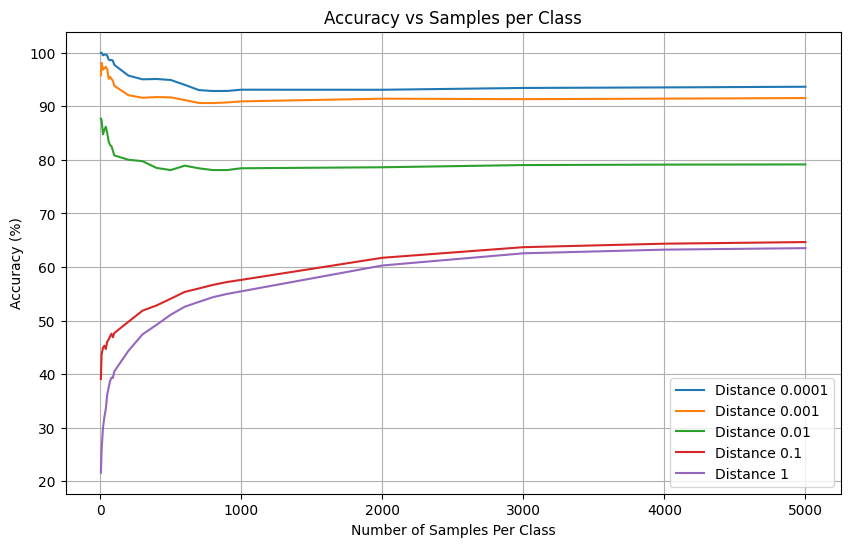

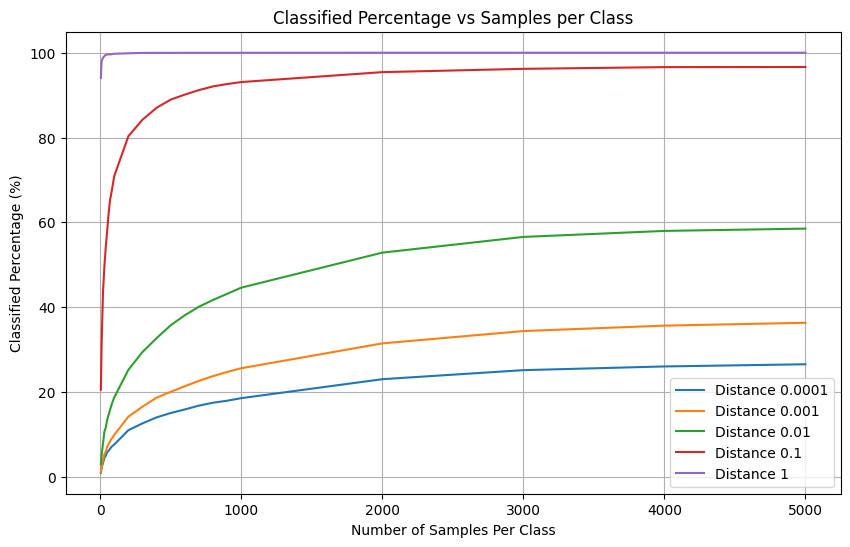

In [70]:
plt.figure(figsize=(10, 6))
for distance, accuracies in accuracy_results.items():
    plt.plot(samples, accuracies, label=f'Distance {distance}')
plt.xlabel('Number of Samples Per Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Samples per Class')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for distance, percentages in classified_results.items():
    plt.plot(samples, percentages, label=f'Distance {distance}')
plt.xlabel('Number of Samples Per Class')
plt.ylabel('Classified Percentage (%)')
plt.title('Classified Percentage vs Samples per Class')
plt.legend()
plt.grid(True)
plt.show()

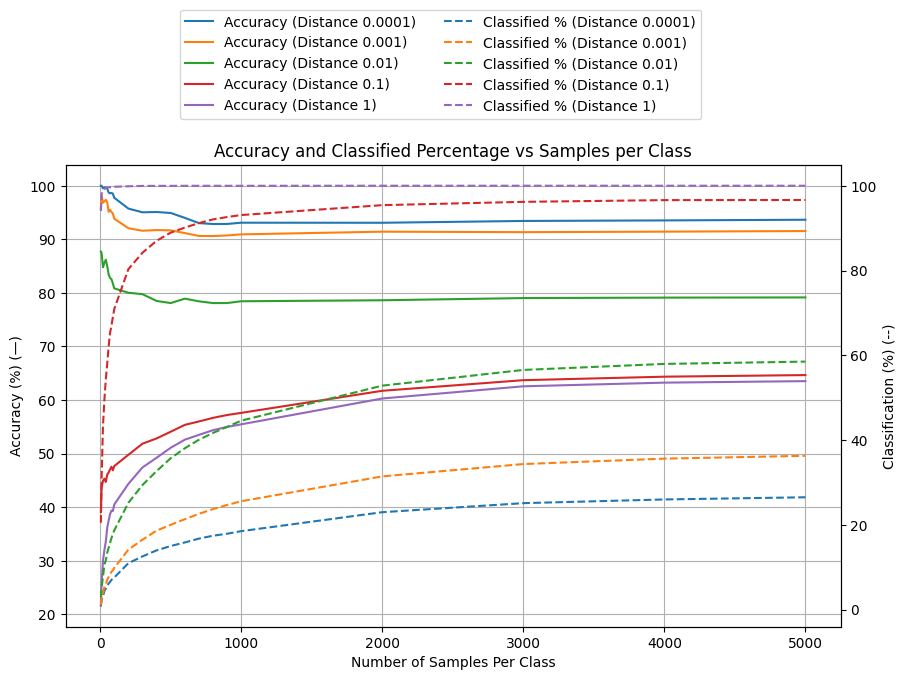

In [85]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy on the primary y-axis
for distance, accuracies in accuracy_results.items():
    ax1.plot(samples, accuracies, label=f'Accuracy (Distance {distance})', linestyle='-')
ax1.set_xlabel('Number of Samples Per Class')
ax1.set_ylabel('Accuracy (%) (—)')
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a secondary y-axis for classified percentage
ax2 = ax1.twinx()
for distance, percentages in classified_results.items():
    ax2.plot(samples, percentages, label=f'Classified % (Distance {distance})', linestyle='--')
ax2.set_ylabel('Classification (%) (--)')
ax2.tick_params(axis='y')

# Add a legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.title('Accuracy and Classified Percentage vs Samples per Class')
plt.show()

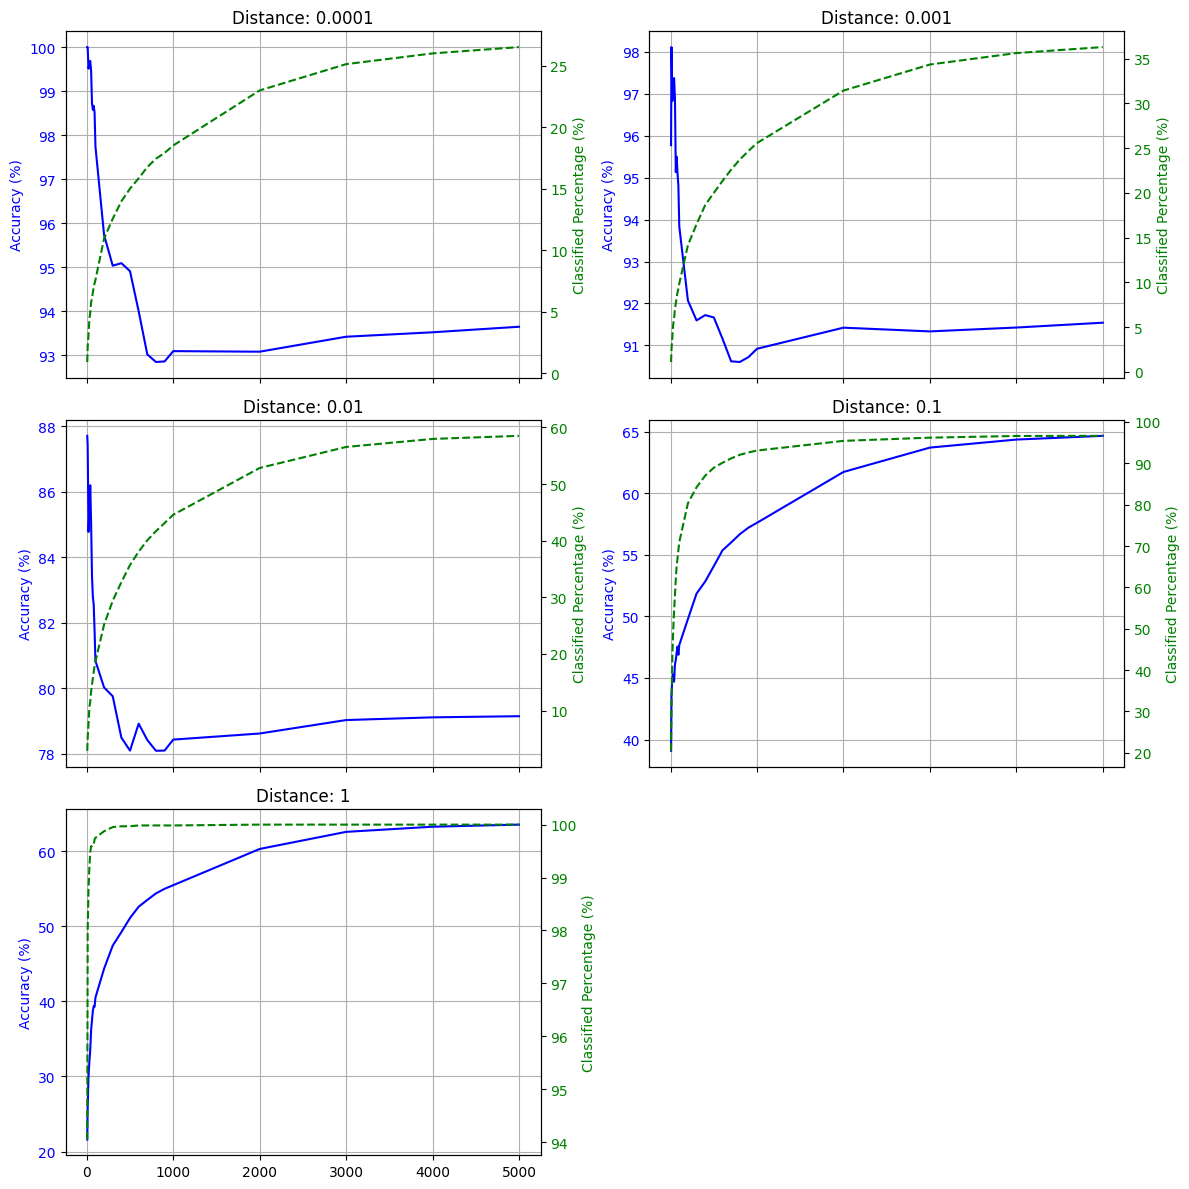

In [93]:
# Create subplots: 2 columns for each distance
num_distances = len(distances)
fig, axes = plt.subplots((num_distances + 1) // 2, 2, figsize=(12, 4 * ((num_distances + 1) // 2)), sharex=True)

# Flatten axes for easier indexing
axes = axes.flatten()

for i, distance in enumerate(distances):
    ax = axes[i]  # Get the current subplot
    
    # Plot accuracy
    ax.plot(samples, accuracy_results[distance], label='Accuracy', color='blue')
    ax.set_ylabel('Accuracy (%)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f'Distance: {distance}')
    ax.grid(True)
    
    # Create a secondary y-axis for classified percentage
    ax2 = ax.twinx()
    ax2.plot(samples, classified_results[distance], label='Classified %', color='green', linestyle='--')
    ax2.set_ylabel('Classified Percentage (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # # Add legends
    # ax.legend(loc='upper left')
    # ax2.legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set common x-axis label
plt.xlabel('Number of Samples Per Class')
plt.tight_layout()
plt.show()

In [40]:
index_embeddings, selected_indices = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'euclidean', None)
classified_embeddings, top_1_embeddings = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices, index_embeddings, "distance")

print(f"Embeddings euclidean classified percentage: {classified_embeddings:.2f}%")
print(f"Embeddings euclidean match in top neighbor: {top_1_embeddings:.2f}%")

Embeddings euclidean classified percentage: 100.00%
Embeddings euclidean match in top neighbor: 79.39%


In [41]:
index_embeddings_cosine, selected_indices = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'cosine', None)
classified_embeddings_cosine, top_1_embeddings_cosine = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices, index_embeddings_cosine, "similarity")

print(f"Embeddings cosine classified percentage: {classified_embeddings_cosine:.2f}%")
print(f"Embeddings cosine match in top neighbor: {top_1_embeddings_cosine:.2f}%")

Embeddings cosine classified percentage: 100.00%
Embeddings cosine match in top neighbor: 80.90%
